In [2]:
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `clean_measurement.sqlite` database file
engine = create_engine("sqlite:///cleaned_measurements.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()


In [6]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement & station classes to a variable called `Measure & Station`
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

In [9]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measure).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a154ae7f0>,
 'date': '2010-01-01',
 'obs': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [10]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a154c1208>,
 'elevation': None,
 'latitude': None,
 'longitude': None,
 'name': None,
 'st_id': 1,
 'station': 'USC00519397'}

In [10]:
# PRECIPITATION ANALYSIS

In [11]:
session = Session(bind=engine)

In [12]:
#Datetime calculation
start_date = dt.date(2016, 4, 1)
end_date = start_date + dt.timedelta(days=365)
print(end_date)

2017-04-01


In [13]:
# Original Code.

sel = [Measure.date,
       (Measure.prcp)]
rain_date = session.query(*sel).\
filter(Measure.date >= start_date).\
filter(Measure.date <= end_date).all()


In [14]:
rain_date2 = pd.DataFrame(rain_date, columns=['date','prcp'])
rain_date2.set_index(rain_date2['date'], inplace=True)
#rain_date2 = rain_date2.rename_axis(None)

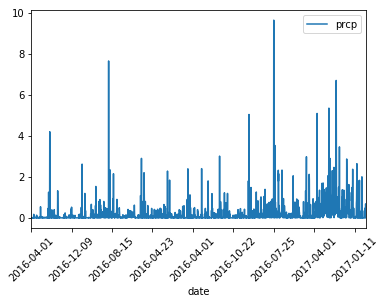

In [15]:
rain_date2.plot()
plt.xticks(rotation=45)
plt.show()

In [16]:
rain_date2.describe()

,prcp
count,2071.000000
mean,0.202559
std,0.548925
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [17]:
#Station Analysis

In [17]:
# count number of stations and show the number of observations.
q = session.query(Measure.station, func.count(Measure.station)).group_by(Measure.station).\
    order_by(func.count(Measure.station).desc()).all()
print(q)
#First element in the array show the highest number of observations.

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


In [18]:
st_81= session.query(Measure.station,(Measure.tobs)).\
filter(Measure.station == 'USC00519281').all()

In [19]:
# Creating a DataFrame of variable - st_81
st_81 = pd.DataFrame(st_81, columns=['tobs', 'station'])

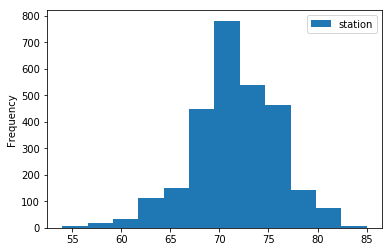

In [20]:
# Histogram of observations from station =USC00591281
st_81.plot.hist(bins=12)
plt.show()

In [22]:
#Temperature Analysis

In [21]:
# start_date = dt.date(2016, 4, 1)
# end_date = start_date + dt.timedelta(days=365)

def calc_temps(start_date, end_date):
    return session.query(func.min(Measure.tobs),func.max(Measure.tobs),func.avg(Measure.tobs)).\
        filter(Measure.date >= start_date).\
        filter(Measure.date <= end_date).all()
                         
print (calc_temps('2016-04-01', '2017-04-01'))

[(59, 84, 74.22742636407533)]


In [57]:
# # Filtering code for date range.

# sel = [func.min(Measure.tobs),func.max(Measure.tobs),func.avg(Measure.tobs)]
# rain_date = session.query(*sel).\
# filter(Measure.date >= start_date).\
# filter(Measure.date <= end_date).all()

In [22]:
vacay_temp = calc_temps('2016-04-01', '2017-04-01')
print(vacay_temp)

[(59, 84, 74.22742636407533)]


In [23]:
tmin, tmax, tavg = calc_temps('2016-04-01', '2017-04-01')[0]
print(tmin, tmax, tavg)

59 84 74.22742636407533


In [24]:
yerr = tmax-tmin
yerr

25

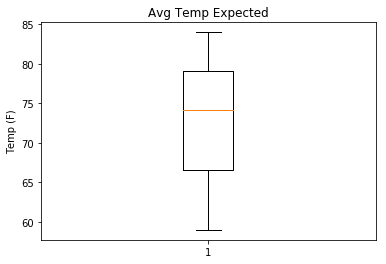

In [25]:
plt.boxplot(vacay_temp)
plt.title('Avg Temp Expected')
plt.ylabel('Temp (F)')
plt.show()

In [36]:
def avg_temps(date): #creating a definition that will queary specify dates (looping) through all of the dates in the dataframe.
    return session.query(func.min(Measure.tobs),func.max(Measure.tobs),func.avg(Measure.tobs)).\
        filter(func.strftime("%m-%d",Measure.date) == date).all()
   

[(61, 80, 72.16363636363636)]


In [79]:
vacay_time2 = '2016-04-01' #This the hard coded start date with year
vacay_time3 = '2017-04-01'
vacay_dates = pd.date_range(vacay_time2, vacay_time3, freq='D')
vacay_month_day = vacay_dates.strftime('%m-%d')
vacay_days = [] # will hold query for all the dates hard coded above in this cell.
for date in vacay_month_day:
    vacay_days.append(*avg_temps(date)) #*creates one list of multiple dates and avg's


In [81]:
# Creating a DataFrame of variable - vacay_dat
vacay_dat= pd.DataFrame(vacay_days, columns=['tmin', 'tmax', 'tavg'])
vacay_dat['date'] = vacay_dates
vacay_dat.set_index(['date'], inplace=True)
vacay_dat.head()

,tmin,tmax,tavg
date,,,
2016-04-01,61,80,72.163636
2016-04-02,53,79,71.673077
2016-04-03,55,78,72.129630
2016-04-04,58,78,72.000000
2016-04-05,61,80,72.206897


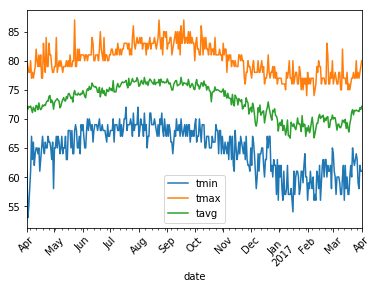

In [90]:
vacay_dat.plot()
plt.xticks(rotation=45)
plt.show()

In [86]:
x = np.arange(len(vacay_days))
y1 = np.arange(vacay_dat('tmin'))
y2 = np.arange(vacay_dat('tmax'))
y3 = np.arange(vacay_dat('tavg'))

y = np.vstack([y1, y2, y3])

labels = ["tmin ", "tmax", "tavg"]

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc=2)
plt.show()

AttributeError: module 'numpy' has no attribute 'vacay_dat'